In [1]:
import overpy
op = overpy.Overpass()
import geopandas as gp
import pandas as pd
from shapely.geometry import shape, Polygon,LineString, MultiPolygon
from shapely.ops import polygonize
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
import utils.close_holes
import utils.osm

In [25]:
bb = "(33.85972509642107,35.46144957007879,33.91857725200028,35.572185442725925)"

osm_data = op.query(f"""
[timeout:25];
(
  way["highway"="motorway"]{bb};
  way["highway"="trunk"]{bb};
  way["highway"="primary"]{bb};
  way["highway"="secondary"]{bb};
  way["highway"="tertiary"]{bb};
  way["highway"="residential"]{bb};
  way["highway"="unclassified"]{bb};
  // way[building]{bb};
  relation["admin_level"="4"]{bb};
);
(._;>;);
out body;
""")

In [26]:

def nodes_to_linestring(nodes):
	points = [(n.lon, n.lat) for n in nodes]
	return LineString(points)

def nodes_to_polygon(nodes):
	points = [(n.lon, n.lat) for n in nodes]
	return Polygon(points)

streets_dict = [{
    'id': way.id,
	'highway': way.tags.get("highway"),
    'geometry': nodes_to_linestring(way.nodes),
} for way in list(filter(lambda x: x.tags.get("highway") != None, osm_data.ways))]
streets = gp.GeoDataFrame(streets_dict, crs="EPSG:4326")

boundary_dict = [{
    'id': rel.id,
    'geometry': utils.osm.rel_to_multipolygon(osm_data, rel),
} for rel in osm_data.relations]
bounds = gp.GeoDataFrame(boundary_dict, crs="EPSG:4326")

streets.to_file("./tmp/beirut_streets.geojson")
bounds.to_file("./tmp/beirut_bounds.geojson")


<Axes: >

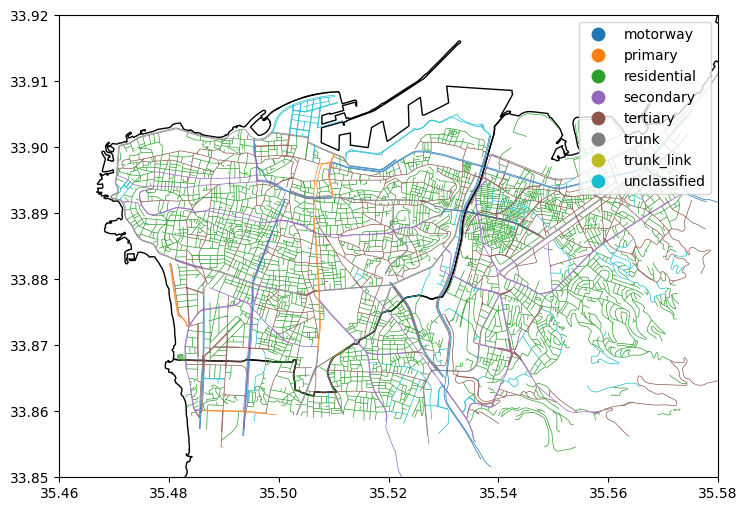

In [28]:
# Plot

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim([35.46,35.58])
ax.set_ylim([33.85, 33.92])

streets.plot(ax=ax, column="highway",legend=True, lw=.5)
bounds.plot(ax=ax, edgecolor='black', color="none", zorder=-10)
